In [1]:
# Install required libraries (if not already installed)
!pip install torch torchvision numpy matplotlib scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE


In [3]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set random seed for reproducibility
torch.manual_seed(42)

# Load Fashion MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


100%|██████████| 26.4M/26.4M [00:01<00:00, 20.1MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 304kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.53MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 19.2MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [4]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 2 * latent_dim)  # Mean and log variance
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 784),
            nn.Sigmoid()  # Output in [0, 1]
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten the input
        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=1)  # Split into mean and log variance
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar


In [5]:
# Hyperparameters
latent_dim = 20
learning_rate = 1e-3
num_epochs = 10  # Reduce for faster execution in Colab

# Initialize model and optimizer
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Loss Function: Reconstruction Loss + KL Divergence
def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction="sum")
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

# Training Loop
train_losses = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}")


Epoch [1/10], Train Loss: 288.5663
Epoch [2/10], Train Loss: 253.6609
Epoch [3/10], Train Loss: 248.9895
Epoch [4/10], Train Loss: 246.6300
Epoch [5/10], Train Loss: 244.8142
Epoch [6/10], Train Loss: 243.3184
Epoch [7/10], Train Loss: 242.3029
Epoch [8/10], Train Loss: 241.5729
Epoch [9/10], Train Loss: 240.9842
Epoch [10/10], Train Loss: 240.5063


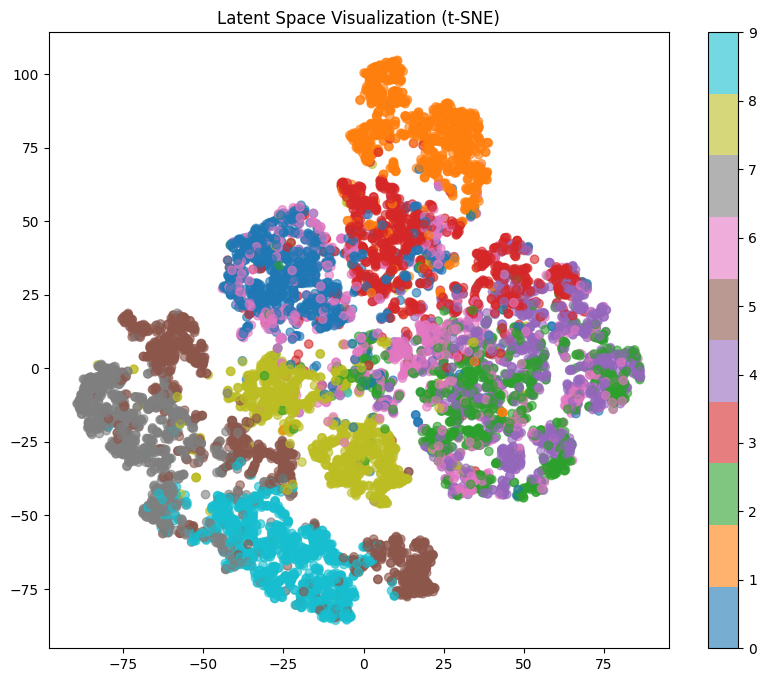

In [6]:
# Visualize Latent Space using t-SNE
def visualize_latent_space(model, data_loader, device):
    model.eval()
    latent_vectors = []
    labels = []
    with torch.no_grad():
        for data, label in data_loader:
            data = data.to(device)
            mu, _ = model.encoder(data.view(-1, 784)).chunk(2, dim=1)
            latent_vectors.append(mu.cpu())
            labels.append(label)
    latent_vectors = torch.cat(latent_vectors, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    latent_2d = tsne.fit_transform(latent_vectors)

    # Plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap="tab10", alpha=0.6)
    plt.colorbar(scatter)
    plt.title("Latent Space Visualization (t-SNE)")
    plt.show()

visualize_latent_space(model, test_loader, device)


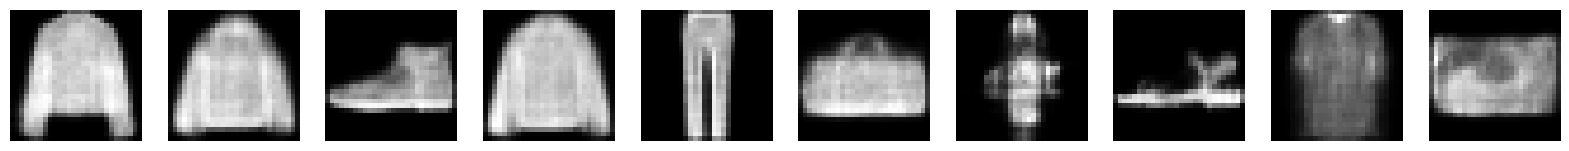

In [7]:
# Generate New Images
def generate_images(model, latent_dim, device, n=10):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n, latent_dim).to(device)
        generated_images = model.decoder(z).cpu()
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(generated_images[i].view(28, 28), cmap="gray")
        plt.axis("off")
    plt.show()

generate_images(model, latent_dim, device)


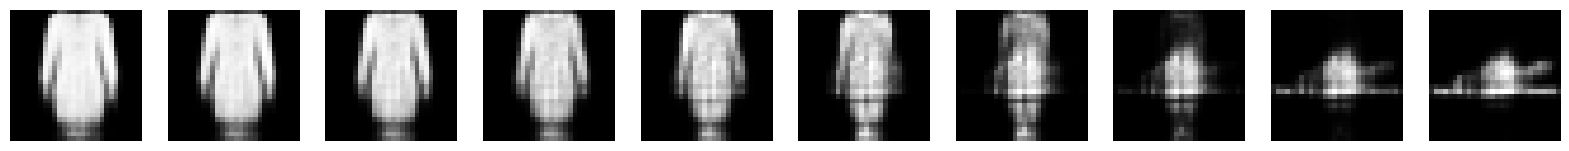

In [8]:
# Interpolate between two points in the latent space
def interpolate(model, z1, z2, n=10):
    model.eval()
    with torch.no_grad():
        interpolated_images = []
        for alpha in np.linspace(0, 1, n):
            z = alpha * z1 + (1 - alpha) * z2
            recon = model.decoder(z).cpu()
            interpolated_images.append(recon)
    plt.figure(figsize=(20, 4))
    for i, img in enumerate(interpolated_images):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(img.view(28, 28), cmap="gray")
        plt.axis("off")
    plt.show()

# Sample two random points in the latent space
z1 = torch.randn(1, latent_dim).to(device)
z2 = torch.randn(1, latent_dim).to(device)
interpolate(model, z1, z2)


In [9]:
# Evaluate on Test Data
model.eval()
test_loss = 0
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        recon_batch, mu, logvar = model(data)
        test_loss += loss_function(recon_batch, data, mu, logvar).item()
test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.4f}")


Test Loss: 242.3178
